Saving dataset_review_tukang.xlsx to dataset_review_tukang.xlsx
Model Summary:


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 10.5479 - mae: 2.9732 - val_loss: 9.8752 - val_mae: 2.7774
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.9745 - mae: 2.8426 - val_loss: 9.1062 - val_mae: 2.6545
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.9488 - mae: 2.7216 - val_loss: 8.2511 - val_mae: 2.5093
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.9505 - mae: 2.7156 - val_loss: 7.2443 - val_mae: 2.3304
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.0150 - mae: 2.3486 - val_loss: 6.1754 - val_mae: 2.1267
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.9741 - mae: 2.1738 - val_loss: 5.0790 - val_mae: 1.8959
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6413 - mae: 1.8851 - val_loss: 4.0213 - val_mae: 1.6449
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8677 - mae: 1.7179 - val_loss: 3.0221 - val_mae: 1.4124
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4749 - mae

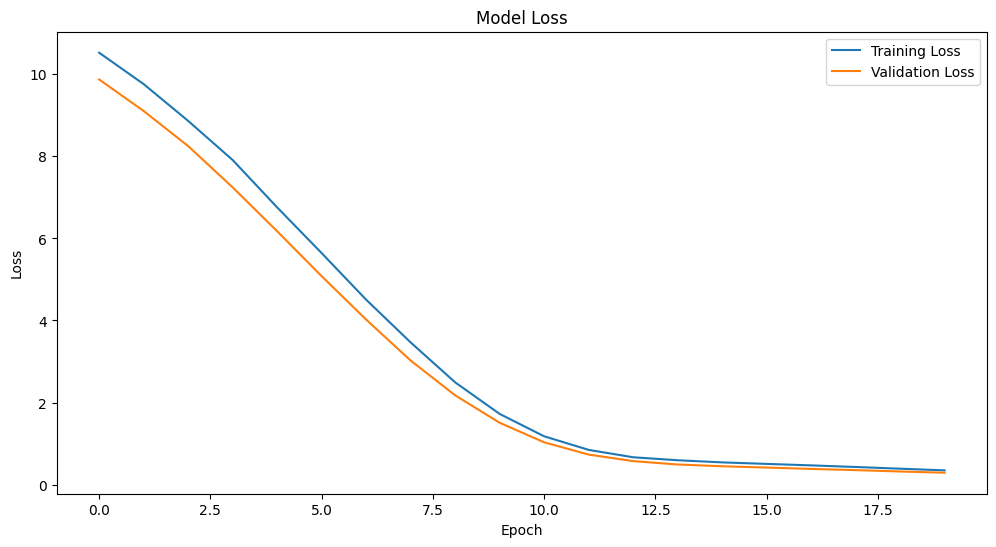

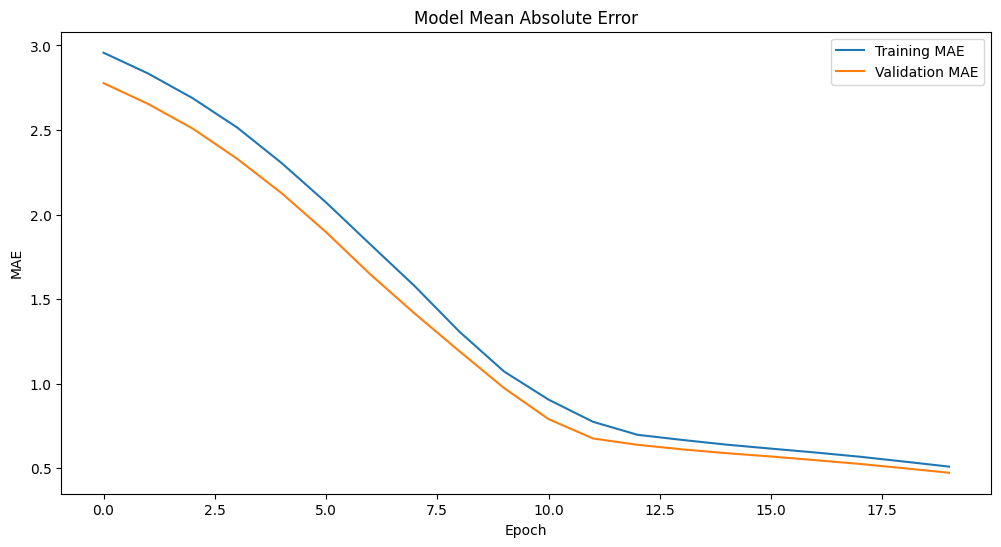

Model and scaler saved.


In [1]:
# Install libraries
!pip install tensorflow flask-ngrok pandas numpy scikit-learn

# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib

# Simulasi data geolokasi (longitude, latitude) untuk pengguna dan tukang
def simulate_geolocation(df):
    np.random.seed(42)
    df['User_Longitude'] = np.random.uniform(95, 141, size=len(df))  # Indonesia's longitude range
    df['User_Latitude'] = np.random.uniform(-10, 6, size=len(df))    # Indonesia's latitude range
    df['Tukang_Longitude'] = np.random.uniform(95, 141, size=len(df))
    df['Tukang_Latitude'] = np.random.uniform(-10, 6, size=len(df))
    return df

# Load dataset
from google.colab import files
uploaded = files.upload()

# Baca dataset yang diunggah
file_name = list(uploaded.keys())[0]
df = pd.read_excel(file_name)

# Tambahkan geolokasi
df = simulate_geolocation(df)

# Fitur tambahan: hitung jarak geografis
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi/2.0)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(delta_lambda/2.0)**2
    return R * 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

df['Distance'] = haversine_distance(
    df['User_Latitude'], df['User_Longitude'],
    df['Tukang_Latitude'], df['Tukang_Longitude']
)

# Feature selection
features = ['Distance', 'Rate']
target = 'Rate'

X = df[features]
y = df[target]

# Normalize data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Save scaler
joblib.dump(scaler, "scaler.pkl")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build TensorFlow model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)  # Predict preference score
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print model summary
print("Model Summary:")
model.summary()

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=8)

# Save the trained model
model.save("tukang_recommender.h5")

# Print training results
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation MAE
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

print("Model and scaler saved.")

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.17.1
